Veri Seti Boyutu: (1911073, 43)


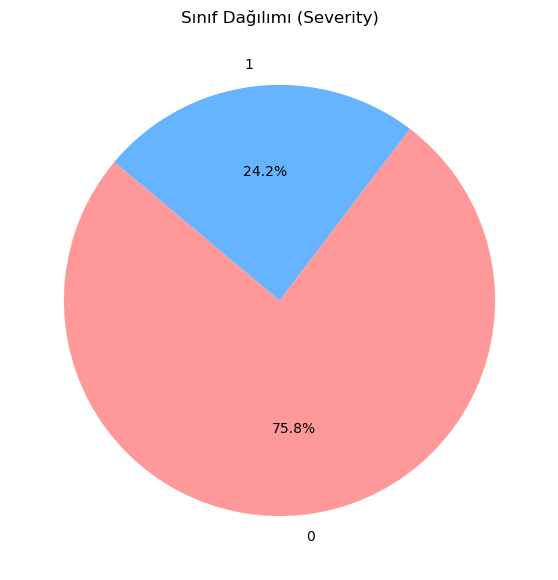

In [1]:
"""Bu bölümde, analiz ve modelleme için gerekli tüm kütüphaneleri çağırıp NYC kaza verisetini 
yüklüyoruz. Verinin yapısını anlamak adına kaza ciddiyetine (Severity) göre dağılımı 
bir pasta grafiğiyle görselleştiriyor; ardından konum, araç tipi ve zaman gibi kritik 
faktörleri seçerek modeli eğitmek üzere girdi ve hedef verilerini hazır hale getiriyoruz."""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
warnings.filterwarnings('ignore')
file_path = 'C:/Users/semii/Downloads/Semih_ALTUN_22040301077_MaslakOtoSanayi/NYC_Crash_Model_Final_Last.csv' 
df = pd.read_csv(file_path)

print(f"Veri Seti Boyutu: {df.shape}")

plt.figure(figsize=(7, 7))
df['SEVERITY'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title("Sınıf Dağılımı (Severity)")
plt.ylabel("")
plt.show()

features = [
    'LATITUDE', 
    'LONGITUDE', 
    'BOROUGH_BRONX', 
    'BOROUGH_BROOKLYN', 
    'BOROUGH_MANHATTAN', 
    'BOROUGH_QUEENS', 
    'BOROUGH_STATEN ISLAND',
    'IS_MULTI_VEHICLE', 
    'VEHICLE_1_GROUP_Heavy Duty', 
    'VEHICLE_1_GROUP_Two Wheeler',
    'VEHICLE_2_GROUP_Heavy Duty', 
    'VEHICLE_2_GROUP_Two Wheeler',
    'FACTOR_1_GROUP_Aggressive Driving', 
    'FACTOR_1_GROUP_Impaired',
    'FACTOR_1_GROUP_Distracted',
    'HOUR', 'DAY_OF_WEEK',
    'ROAD_TYPE_ARTERIES_HIGHWAYS', 
    'ROAD_TYPE_LOCAL_MAIN_ROADS'
]
X = df[features].values
y = df['SEVERITY'].values

In [2]:
"""Bu aşamada, veriyi model eğitimi ve testi için ikiye ayırıyor (train/test split) ve 
eğitim setindeki sınıf dengesizliğini gidermek adına SMOTE tekniği ile azınlık sınıfı 
için sentetik veriler üretiyoruz. Son olarak, algoritmaların daha kararlı çalışması 
için verileri standartlaştırarak (scaling) aynı ölçeğe getiriyor ve işlem öncesi-sonrası 
değişimi kontrol ediyoruz."""

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("SMOTE uygulanıyor...")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)
print(f"SMOTE öncesi eğitim seti dağılımı: {Counter(y_train)}")
print(f"SMOTE sonrası eğitim seti dağılımı: {Counter(y_train_res)}")

SMOTE uygulanıyor...
SMOTE öncesi eğitim seti dağılımı: Counter({np.int64(0): 1013478, np.int64(1): 324273})
SMOTE sonrası eğitim seti dağılımı: Counter({np.int64(0): 1013478, np.int64(1): 1013478})


In [3]:
"""Bu fonksiyon, modelimizin tahmin başarısını ve nerelerde hata yaptığını net bir şekilde 
görebilmemiz için karmaşıklık matrisini (confusion matrix) görselleştiriyor. Gerçek veriler 
ile modelin tahminlerini karşılaştırarak, sonuçları belirlediğimiz bir başlık altında 
okunması kolay, mavi tonlu bir grafik olarak ekrana yansıtıyor."""

def plot_confusion_matrix(y_true, y_pred, title):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(title)
    plt.show()


In [4]:
"""Bu satırda, modelimizin başarısını tek bir testle sınırlamayıp daha güvenilir bir yöntemle 
ölçmek için K-Katlı Çapraz Doğrulama (Stratified K-Fold) yapısını kuruyoruz. Veriyi 
karıştırıp 3 parçaya bölerken sınıf oranlarını (dengesini) koruyoruz; böylece eğitimin 
tutarlı ve sonuçların her durumda geçerli olduğundan emin olacağız."""

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

Random Forest Tuning Başlatılıyor...
En İyi RF Parametreleri: {'max_depth': 15, 'n_estimators': 100}

Random Forest Model Değerlendirme Başlatılıyor...
Test Accuracy: 0.7200


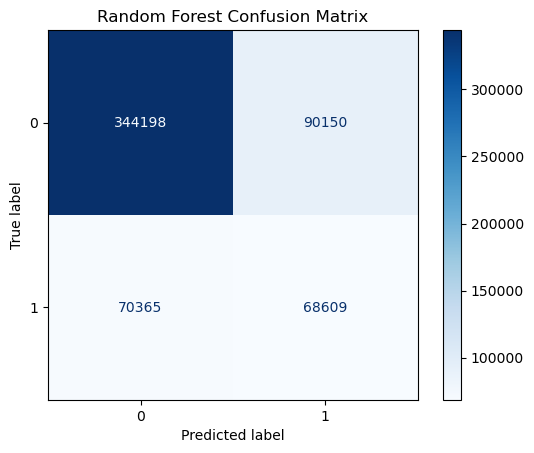


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81    434348
           1       0.43      0.49      0.46    138974

    accuracy                           0.72    573322
   macro avg       0.63      0.64      0.64    573322
weighted avg       0.73      0.72      0.73    573322



In [5]:
"""Bu bölümde, Random Forest algoritmasının en yüksek performansı verecek ayarlarını bulmak 
için otomatik bir tarama (tuning) başlatıyoruz. Farklı parametreleri deneyip en başarılı 
modeli seçtikten sonra, bu modeli test verisi üzerinde sınıyor; sonuçları doğruluk oranı, 
hata matrisi ve detaylı sınıflandırma raporuyla net bir şekilde ortaya koyuyoruz."""

print("Random Forest Tuning Başlatılıyor...")
rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 15]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=skf, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train_scaled, y_train_res)
print(f"En İyi RF Parametreleri: {grid_rf.best_params_}")
rf_best = grid_rf.best_estimator_

print("\nRandom Forest Model Değerlendirme Başlatılıyor...")

y_pred = rf_best.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

XGBoost Tuning Başlatılıyor...
En İyi XGBoost Parametreleri: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100}

XGBoost Model Değerlendirme Başlatılıyor...
Test Accuracy: 0.7073

Confusion Matrix:


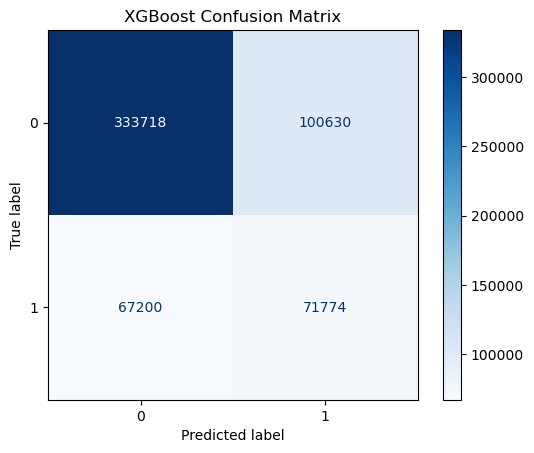


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.77      0.80    434348
           1       0.42      0.52      0.46    138974

    accuracy                           0.71    573322
   macro avg       0.62      0.64      0.63    573322
weighted avg       0.73      0.71      0.72    573322



In [6]:
"""Bu aşamada, güçlü bir algoritma olan XGBoost'u devreye alıyoruz. Modelin en yüksek performansı 
sergilemesi için öğrenme oranı ve derinlik gibi kritik ayarlarını optimize ediyor (tuning), 
en iyi versiyonu bulduktan sonra test verisiyle sınıyoruz. Son olarak, modelin ne kadar 
isabetli tahmin yaptığını doğruluk oranı, hata matrisi ve detaylı raporlarla analiz ederek 
sonuçları netleştiriyoruz."""

print("XGBoost Tuning Başlatılıyor...")
xgb_params = {'learning_rate': [0.1], 'max_depth': [5, 8], 'n_estimators': [100]}
grid_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), 
                        xgb_params, cv=skf, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train_scaled, y_train_res)
print(f"En İyi XGBoost Parametreleri: {grid_xgb.best_params_}")
xgb_best = grid_xgb.best_estimator_

print("\nXGBoost Model Değerlendirme Başlatılıyor...")

y_pred = xgb_best.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format='d', cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [7]:
"""Bu adımda, hazırladığımız sayısal verileri derin öğrenme modelimizin (PyTorch) anlayabileceği 
yapıtaşları olan 'Tensör' formatına çeviriyoruz. Ardından, modelin eğitimi sırasında 
veriyi daha verimli işleyebilmesi için 2048'lik paketler (batch) halinde ve her seferinde 
karıştırarak sunacak olan akıllı veri yükleyiciyi (DataLoader) hazırlıyoruz."""

X_train_t = torch.FloatTensor(X_train_scaled)
y_train_t = torch.LongTensor(y_train_res)
X_test_t  = torch.FloatTensor(X_test_scaled)

train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=2048,
    shuffle=True
)

MLP Eğitimi Tamamlandı.

MLP Model Değerlendirme Başlatılıyor...
Test Accuracy: 0.7003

Confusion Matrix:


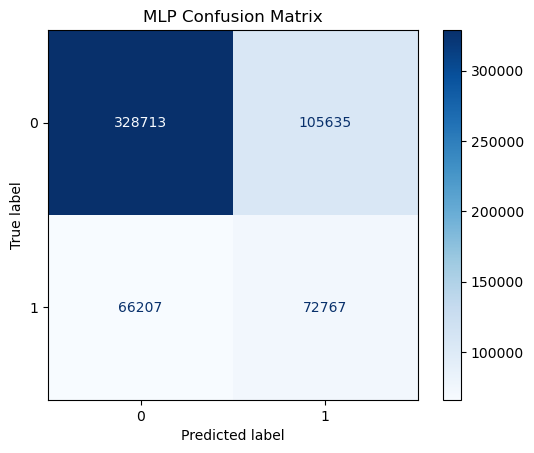


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.76      0.79    434348
           1       0.41      0.52      0.46    138974

    accuracy                           0.70    573322
   macro avg       0.62      0.64      0.63    573322
weighted avg       0.73      0.70      0.71    573322



In [8]:
"""Bu bölümde, projenin derin öğrenme ayağını oluşturuyoruz. `MLPCrasher` adını verdiğimiz 
çok katmanlı bir yapay sinir ağı (MLP) mimarisi tasarlayıp, hazırladığımız verilerle 
bu ağı eğitiyoruz. Eğitim tamamlandığında, modelin hiç görmediği test verileri üzerindeki 
tahmin başarısını ölçüyor ve sonuçları detaylı grafikler ve raporlarla analiz ediyoruz."""

class MLPCrasher(nn.Module):
    def __init__(self, input_dim):
        super(MLPCrasher, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.net(x)


# --- MLP Eğitim Fonksiyonu ---
def train_mlp(model, loader, epochs=5):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    for epoch in range(epochs):
        for bx, by in loader:
            optimizer.zero_grad()
            loss = criterion(model(bx), by)
            loss.backward()
            optimizer.step()
    print("MLP Eğitimi Tamamlandı.")


mlp_model = MLPCrasher(X_train_scaled.shape[1])
train_mlp(mlp_model, train_loader)

print("\nMLP Model Değerlendirme Başlatılıyor...")

mlp_model.eval()
with torch.no_grad():
    outputs = mlp_model(X_test_t)

    y_pred = torch.argmax(outputs, dim=1).cpu().numpy()

y_true = y_test

acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {acc:.4f}")

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, values_format='d', cmap='Blues')
plt.title("MLP Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred))


RNN Eğitimi Tamamlandı.

RNN Model Değerlendirme Başlatılıyor...
Test Accuracy: 0.6680

Confusion Matrix:


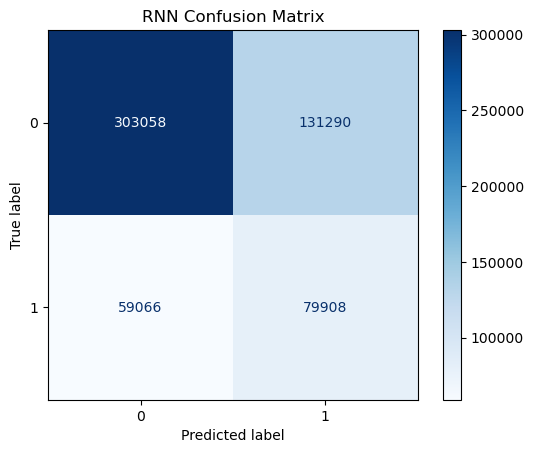


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.70      0.76    434348
           1       0.38      0.57      0.46    138974

    accuracy                           0.67    573322
   macro avg       0.61      0.64      0.61    573322
weighted avg       0.73      0.67      0.69    573322



In [9]:
"""Bu bölümde, genellikle sıralı verilerde kullanılan RNN (Recurrent Neural Network) yapısını 
kaza analizine uyarlıyoruz. Veriyi bu ağın işleyebileceği özel formata (3 boyutlu) 
dönüştürerek modeli eğitiyor; ardından bu yaklaşımın ne kadar başarılı olduğunu görmek 
için test seti üzerinde tahminler yapıp sonuçları detaylı grafik ve raporlarla sunuyoruz."""

class RNNCrasher(nn.Module):
    def __init__(self, input_dim):
        super(RNNCrasher, self).__init__()
        self.rnn = nn.RNN(input_dim, 32, batch_first=True)
        self.fc = nn.Linear(32, 2)

    def forward(self, x):
        # RNN 3D giriş ister: (Batch, Seq, Features)
        x = x.unsqueeze(1)
        _, h_n = self.rnn(x)
        return self.fc(h_n.squeeze(0))

def train_rnn(model, loader, epochs=5):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    for epoch in range(epochs):
        for bx, by in loader:
            optimizer.zero_grad()
            loss = criterion(model(bx), by)
            loss.backward()
            optimizer.step()
    print("RNN Eğitimi Tamamlandı.")

rnn_model = RNNCrasher(X_train_scaled.shape[1])
train_rnn(rnn_model, train_loader)

print("\nRNN Model Değerlendirme Başlatılıyor...")

rnn_model.eval()
with torch.no_grad():
    outputs = rnn_model(X_test_t)
    
    y_pred = torch.argmax(outputs, dim=1).cpu().numpy()

y_true = y_test

acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {acc:.4f}")

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format='d', cmap='Blues')
plt.title("RNN Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred))


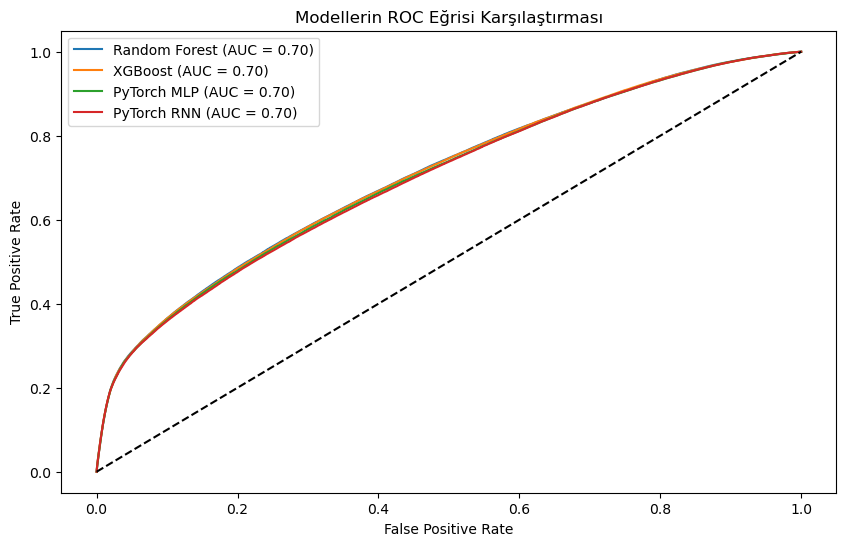


--- Tablo 1: Genel Karşılaştırma ---


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Model,,,,,
Random Forest,0.720026,0.733765,0.720026,0.726066,0.704546
XGBoost,0.707267,0.731528,0.707267,0.717124,0.704022
PyTorch MLP,0.700270,0.729461,0.700270,0.711762,0.700608
PyTorch RNN,0.667977,0.725741,0.667977,0.687164,0.698910


,precision,recall,f1-score,support
0,0.830267,0.792448,0.810917,434348.000000
1,0.432158,0.493682,0.460876,138974.000000
accuracy,0.720026,0.720026,0.720026,0.720026
macro avg,0.631213,0.643065,0.635896,573322.000000
weighted avg,0.733765,0.720026,0.726066,573322.000000


,precision,recall,f1-score,support
0,0.832385,0.768319,0.799070,434348.000000
1,0.416313,0.516456,0.461009,138974.000000
accuracy,0.707267,0.707267,0.707267,0.707267
macro avg,0.624349,0.642388,0.630039,573322.000000
weighted avg,0.731528,0.707267,0.717124,573322.000000


,precision,recall,f1-score,support
0,0.832353,0.756796,0.792779,434348.000000
1,0.407882,0.523602,0.458554,138974.000000
accuracy,0.700270,0.700270,0.700270,0.700270
macro avg,0.620118,0.640199,0.625666,573322.000000
weighted avg,0.729461,0.700270,0.711762,573322.000000


,precision,recall,f1-score,support
0,0.836890,0.697731,0.761001,434348.000000
1,0.378356,0.574985,0.456393,138974.000000
accuracy,0.667977,0.667977,0.667977,0.667977
macro avg,0.607623,0.636358,0.608697,573322.000000
weighted avg,0.725741,0.667977,0.687164,573322.000000


In [10]:
"""Modellerin tahminlerini tek tek toplayıp, hangisinin kazaları daha 
doğru öngördüğünü belirlemek için ROC Eğrileri ile performanslarını görselleştiriyoruz. 
Ayrıca, karmaşık sayıları okumayı kolaylaştırmak adına, en başarılı sonuçları otomatik 
olarak yeşil renkle vurgulayan şık tablolar oluşturarak kazanan modeli ilan ediyoruz."""

def get_pytorch_preds(model, data_tensor):
    model.eval()
    with torch.no_grad():
        out = model(data_tensor)
        probs = torch.softmax(out, dim=1)[:, 1].numpy()
        preds = torch.argmax(out, dim=1).numpy()
    return preds, probs

mlp_preds, mlp_probs = get_pytorch_preds(mlp_model, X_test_t)
rnn_preds, rnn_probs = get_pytorch_preds(rnn_model, X_test_t)
rf_preds, rf_probs = rf_best.predict(X_test_scaled), rf_best.predict_proba(X_test_scaled)[:, 1]
xgb_preds, xgb_probs = xgb_best.predict(X_test_scaled), xgb_best.predict_proba(X_test_scaled)[:, 1]

all_models = {
    "Random Forest": (rf_preds, rf_probs),
    "XGBoost": (xgb_preds, xgb_probs),
    "PyTorch MLP": (mlp_preds, mlp_probs),
    "PyTorch RNN": (rnn_preds, rnn_probs)
}

plt.figure(figsize=(10, 6))
for name, (preds, probs) in all_models.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, probs):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title("Modellerin ROC Eğrisi Karşılaştırması")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

def style_class_report(y_true, y_pred, title):
    rep = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(rep).T

    class_rows = ["0", "1"]
    metrics = ["precision", "recall", "f1-score"]

    def highlight_max_per_class(col):
        if col.name in metrics:
            max_val = col.loc[class_rows].max()
            return [
                "background-color: lightgreen" if (idx in class_rows and val == max_val) else ""
                for idx, val in col.items()
            ]
        return [""] * len(col)

    styled = (
        df.style
        .apply(highlight_max_per_class)
        .set_caption(title)
    )

    return styled

results = []
for name, (preds, probs) in all_models.items():
    rep = classification_report(y_test, preds, output_dict=True)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": rep['weighted avg']['precision'],
        "Recall": rep['weighted avg']['recall'],
        "F1-Score": rep['weighted avg']['f1-score'],
        "ROC-AUC": roc_auc_score(y_test, probs)
    })

performance_df = pd.DataFrame(results)

performance_df_styled = (
    performance_df
    .set_index("Model")
    .style
    .highlight_max(axis=0, color="lightgreen")
)

print("\n--- Tablo 1: Genel Karşılaştırma ---")
display(performance_df_styled)

display(style_class_report(y_test, rf_preds,  "Random Forest – Sınıf Bazlı Kırılım"))
display(style_class_report(y_test, xgb_preds, "XGBoost – Sınıf Bazlı Kırılım"))
display(style_class_report(y_test, mlp_preds, "PyTorch MLP – Sınıf Bazlı Kırılım"))
display(style_class_report(y_test, rnn_preds, "PyTorch RNN – Sınıf Bazlı Kırılım"))
